<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
!pip install Keras-applications

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from keras.layers import Add, Activation, ZeroPadding2D, Conv2D, AveragePooling2D, MaxPooling2D 
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D , UpSampling3D
from tensorflow.keras import optimizers
from keras.datasets import cifar100,cifar10,fashion_mnist
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [4]:
def select_dataset(index=1): #1 for cifar10 , 2 for cifar100 , 3 for fashion mnist
  if(index == 1):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    channel = 3
    num_classes = 10
  if(index == 2):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    num_classes = 100
    channel = 3
  if(index == 3):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape((60000, 28, 28, 1))
    x_test =  x_test.reshape((10000, 28, 28, 1))
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    channel = 1
    return (x_train , y_train , x_test , y_test , num_classes , channel)

  #Pre-process the data
  x_train = preprocess_input(x_train)
  x_test = preprocess_input(x_test)

  datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
  datagen.fit(x_train)
  y_train = np_utils.to_categorical(y_train, num_classes)
  y_test = np_utils.to_categorical(y_test, num_classes)

  return (x_train , y_train , x_test , y_test , num_classes , channel , datagen)

In [5]:
def VGG16(num_classes , channel=3):
  model = Sequential()
  weight_decay = 0.0005
  learning_rate = 0.1
  lr_decay = 1e-6
  lr_drop = 20
  if(channel == 3):
    image_shape = (160, 160, 3)
    model.add(UpSampling2D((5,5)))
  else:
    image_shape = (112, 112, 3)
    model.add(UpSampling3D((4,4,3)))

  model.add(Conv2D(64, (3, 3), padding='same',input_shape=image_shape,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dropout(0.25))
  model.add(Dense(num_classes))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))
  sgd = keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  
  return model


In [6]:
index = 1
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = VGG16(num_classes,channel)
model_name = 'desktop/Trained_models/vgg16_cifar10'
model_path = 'desktop/Trained_models/vgg16_cifar10.h5'

In [151]:
index = 2
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
print(num_classes)
model = VGG16(num_classes,channel)
model_name = 'desktop/Trained_models/vgg16_cifar100'
model_path = 'desktop/Trained_models/vgg16_cifar100.h5'

100


In [ ]:
index = 3
x_train , y_train , x_test , y_test , num_classes ,channel  = select_dataset(index)
model = VGG16(num_classes,channel)
model_name = 'desktop/Trained_models/vgg16_mnist'
model_path = 'desktop/Trained_models/vgg16_mnist.h5'

In [7]:
batch_size = 128 # 256 for mnist , 128 for cifar-10 , 32 for cifar-100
epochs=200
callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau( factor = 0.9, patience = 7, min_lr = 0.000001 ),
    #tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 15)
  ]
if(channel == 3):
  history = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks = callbacks)

  model.save(model_path)
else:
  history = model.fit(x_train , y_train , batch_size=batch_size ,steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, validation_data=(x_test, y_test),callbacks=callbacks)
  model.save(model_path)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
390/390 [==============================] - ETA: 0s - loss: 4.2326 - accuracy: 0.3574
Epoch 00001: val_accuracy improved from -inf to 0.28930, saving model to desktop/Trained_models/vgg16_cifar10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: desktop/Trained_models/vgg16_cifar10/assets
390/390 [==============================] - 177s 453ms/step - loss: 4.2326 - accuracy: 0.3574 - val_loss: 4.0103 - val_accuracy: 0.2893 - lr: 0.1000
Epoch 2/200
390/390 [==============================] - ETA: 0s - loss: 2.4826 - accuracy: 0.5661
Epoch 00002: val_accuracy did not improve from 0.28930
390/390 [==============================] - 172s 442ms/step - loss: 2.4826 - accuracy: 0.5661 - val_loss: 4.5547 - val_accuracy: 0.2218 - lr: 0.1000
Epoch 3/200
390/390 [==============================] - ETA: 0s - loss: 1.6730 - accuracy: 0.6768
Epoch 00003:

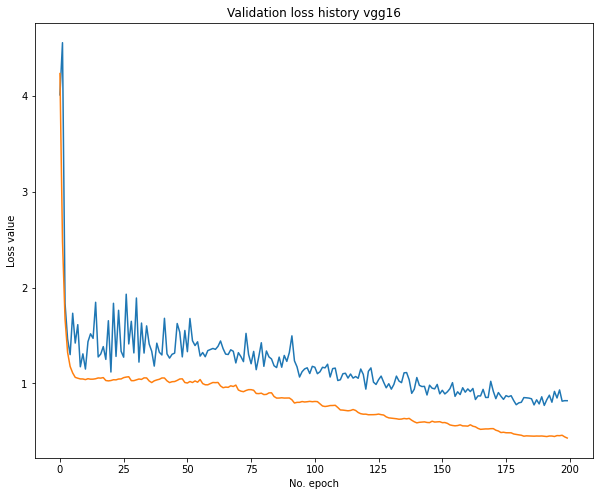

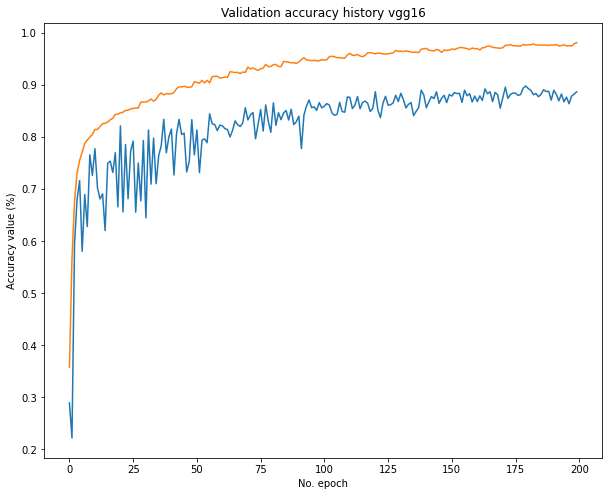

In [8]:
import matplotlib.pyplot as plt

# Visualize history
# Plot history: Loss
plt.figure(figsize = (10,8))
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'],label='Train loss')
plt.title('Validation loss history vgg16')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (10,8))
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.title('Validation accuracy history vgg16')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [9]:
import keras,os
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D , Dropout
import numpy as np
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from keras import regularizers
from absl import app, flags

# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:

def make_prediction(model , image , true_value):
  true_label_index = -1
  for i in range(len(true_value)):

    if(true_value[i]==1):
      true_label_index = i
      break

  prediction = model.predict(image)[0]
  probability = float('-inf')
  predicted_label_index = -1

  for i in range(len(prediction)):

    if(prediction[i]>probability):
      probability = prediction[i]
      predicted_label_index = i

  if(true_label_index!=predicted_label_index):
    return 1
  return 0

In [11]:
model = keras.models.load_model(model_path)

Cifar-100


In [ ]:
from keras.preprocessing.image import img_to_array

epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200

result={}
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(model,image,true_value)
    fgsm_sample = fast_gradient_method(model, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(model, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(model , fgsm_sample , true_value)
    pgd_prediction = make_prediction(model , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1


In [157]:
for key in result.keys():
  print(key,' ',result[key])

0.1   (71, 71)
0.2   (68, 66)
0.30000000000000004   (70, 71)
0.4   (72, 75)
0.5   (80, 75)
0.6   (89, 75)
0.7   (98, 75)
0.7999999999999999   (102, 75)


cifar-10


In [12]:
model = keras.models.load_model(model_path)

In [14]:
from keras.preprocessing.image import img_to_array

epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200

result_cifar10={}
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(model,image,true_value)
    fgsm_sample = fast_gradient_method(model, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(model, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(model , fgsm_sample , true_value)
    pgd_prediction = make_prediction(model , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result_cifar10[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1

Epsilon value -  0.1

0.1   0
0   0
0.1   1
0   0
0.1   2
0   0
0.1   3
0   0
0.1   4
0   0
0.1   5
0   0
0.1   6
0   0
0.1   7
0   0
0.1   8
0   0
0.1   9
0   0
0.1   10
0   0
0.1   11
0   0
0.1   12
0   0
0.1   13
0   0
0.1   14
0   0
0.1   15
0   0
0.1   16
0   0
0.1   17
0   0
0.1   18
0   0
0.1   19
0   0
0.1   20
0   0
0.1   21
0   0
0.1   22
1   1
0.1   23
1   1
0.1   24
2   2
0.1   25
2   2
0.1   26
2   2
0.1   27
2   2
0.1   28
2   2
0.1   29
2   2
0.1   30
2   2
0.1   31
2   2
0.1   32
2   2
0.1   33
2   2
0.1   34
2   2
0.1   35
2   2
0.1   36
2   2
0.1   37
3   3
0.1   38
3   3
0.1   39
3   3
0.1   40
3   3
0.1   41
3   3
0.1   42
3   3
0.1   43
3   3
0.1   44
3   3
0.1   45
3   3
0.1   46
3   3
0.1   47
4   4
0.1   48
4   4
0.1   49
4   4
0.1   50
4   4
0.1   51
4   4
0.1   52
5   5
0.1   53
5   5
0.1   54
5   5
0.1   55
5   5
0.1   56
5   5
0.1   57
6   6
0.1   58
7   7
0.1   59
8   8
0.1   60
8   8
0.1   61
9   9
0.1   62
9   9
0.1   63
9   9
0.1   64
9   9
0.1   65
9   

In [16]:
for key in result_cifar10.keys():
  print(key,' ',result_cifar10[key])

0.1   (28, 28)
0.2   (31, 33)
0.30000000000000004   (33, 36)
0.4   (40, 40)
0.5   (44, 40)
0.6   (50, 40)
0.7   (61, 40)
0.7999999999999999   (69, 40)
